# Question space

In this notebook, I reshape the data, with each question made its own unique dimension. This is done in an effort to explore where students live in question space. Can insights be found?

The following code munges the data to reshape it. This process takes a while to run and hence is commented out. Instead, just load the pickle file in this directory using code below.

In [1]:
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import pandas as pd

In [39]:
df = pd.read_csv('astudentData.csv')

In [2]:
# # reshape data
# def f(row,qid):
#     if row['question_id'] == qid and row['correct'] == 1:
#         val = 1
#     elif row['question_id'] == qid and row['correct'] == 0:
#         val = -1
#     else:
#         val = 0
#     return val

# question_ids = df['question_id'].unique()

# print('starting new column creation')
# start = time.time()
# for i in question_ids:
#     df[i] = df.apply(f,args = (i,), axis=1)
#     print('column {0} created'.format(i))

# end = time.time()
# print(end - start) # 50 seconds for 2. 3 hours for 400 questions!

# # group by users and sum all 0 and 1s in sparse columns to get denser df
# wide_students = df.groupby('user_id').sum()

# wide_students.to_pickle('wide_students')

In [33]:
import pandas as pd
wide = pd.read_pickle('wide_students')
wide.head(2)

,question_id,correct,13,21,26,27,28,37,44,45,...,15071,15142,15147,15403,15412,15413,15415,15865,15872,1232
user_id,,,,,,,,,,,,,,,,,,,,,
34,67509,43,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
324,16838,14,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now, we still have {{wide.shape[0]}} rows for all of our students, but each question was expanded to its own column, with values 0 for NA, 1 for correct, and -1 for incorrect. This allows us to think of the test as a n dimensional space. Let's first drop the unneeded columns.

In [32]:
widee = wide.drop(['question_id','correct'], 1)
widee.head(1)

,13,21,26,27,28,37,44,45,53,54,...,15071,15142,15147,15403,15412,15413,15415,15865,15872,1232
user_id,,,,,,,,,,,,,,,,,,,,,
34,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1


In [79]:
# Convert DataFrame to matrix
n_clusters = 10
mat = widee.as_matrix()
# Using sklearn
km = sklearn.cluster.KMeans(n_clusters=n_clusters)
km.fit(mat)
# Get cluster assignment labels
labels = km.labels_
# Format results as a DataFrame
results = pd.DataFrame([widee.index,labels]).T

In [81]:
pca = results.reset_index()
pca.head(5)

,index,0,1
0,0,34,7
1,1,324,4
2,2,346,1
3,3,350,1
4,4,363,1


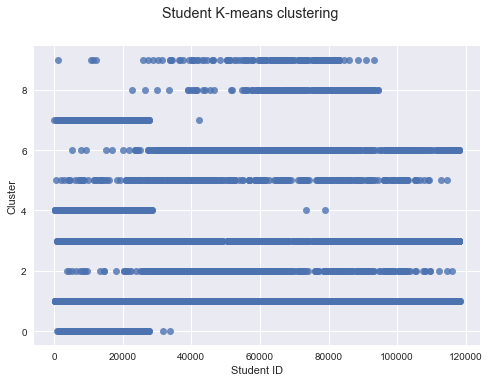

In [82]:
sns.regplot(pca[0],pca[1],fit_reg = False)
sns.plt.xlabel('Student ID')
sns.plt.ylabel('Cluster')
sns.plt.suptitle('Student K-means clustering')
plt.show()

Above, we see the student ids on the x axis, clustered into like groups. Here, I chose 10 clusters because it is easier to visuaize. We would definitely want more clusters if we were going to use this to really try to start to differentiate our test takers. 

For now, though, let's just look at the 10 clusters. Do these actually mean anything?

In [83]:
student_scores = df.groupby('user_id')['correct'].mean().reset_index()
student_scores.head()

,user_id,correct
0,34,0.811321
1,324,0.736842
2,346,0.222222
3,350,0.489583
4,363,0.409091


Let's see what the average score is for each cluster. Hopefully we see some distinctions here?











In [84]:
pca_groups = range(0,n_clusters)
means = []
for i in pca_groups:
    idss = pca[pca[1]==i][0]
    means.append(student_scores.loc[student_scores['user_id'].isin(idss)].mean()[1])

means

[0.81474090654607634,
 0.37687305827906975,
 0.44920543472734953,
 0.76019690394082728,
 0.75136629095663876,
 0.78428453876461213,
 0.76385365329621058,
 0.81969400265152592,
 0.7257193003095026,
 0.81955203154186007]

Hmm...it's unclear if this works. Surely, we do see some clusters with similar means, but if this algorithm worked its magic as we wanted, two groups with similar means could be appropriately tagged as in different clusters (because they scored similarly but on different question sets). This is all to say that I don't know that this strategy (clustering in question space) is a terrible idea, but it is also not yet clear that it's a brilliant one. As always, more to investigate! 